In [586]:
#coding:utf-8
%reload_ext autoreload 
%autoreload 2
from asyncio import Future
import asyncio
from asyncio.queues import Queue
import uvloop
asyncio.set_event_loop_policy(uvloop.EventLoopPolicy())

import tensorflow as tf
import numpy as np
import os
import sys
import random
import time
import argparse
from collections import deque, defaultdict, namedtuple
import scipy.stats
from threading import Lock
from concurrent.futures import ThreadPoolExecutor

gpu_num = 1
os.environ["CUDA_VISIBLE_DEVICES"] = ''#str(gpu_num)

In [587]:
from cchess_zero.gameboard import *

In [588]:
from cchess_zero import board_visualizer
import cv2

In [589]:
from matplotlib import pyplot as plt
%matplotlib inline

In [590]:
from net import resnet

In [16]:
import common
from common import board
labels = common.board.create_uci_labels()

In [17]:
from cchess_zero import mcts

In [18]:
from cchess import *
from common import board
import common
from game_convert import boardarr2netinput

In [19]:
uci_labels = common.board.create_uci_labels()
class GameState():
    def __init__(self):
        self.statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
        self.currentplayer = 'w'
        self.ys = '9876543210'[::-1]
        self.xs = 'abcdefghi'
        self.pastdic = {}
        self.maxrepeat = 0
        self.lastmove = ""
    def get_king_pos(self):
        board = self.statestr.replace("1", " ")
        board = board.replace("2", "  ")
        board = board.replace("3", "   ")
        board = board.replace("4", "    ")
        board = board.replace("5", "     ")
        board = board.replace("6", "      ")
        board = board.replace("7", "       ")
        board = board.replace("8", "        ")
        board = board.replace("9", "         ")
        board = board.split('/')

        for i in range(3):
            pos = board[i].find('K')
            if pos != -1:
                K = "{}{}".format(self.xs[pos],self.ys[i])
        for i in range(-1,-4,-1):
            pos = board[i].find('k')
            if pos != -1:
                k = "{}{}".format(self.xs[pos],self.ys[i])
        return K,k
            
    def game_end(self):
        #if self.statestr.find('k') == -1:
        #    return True,'w'
        #elif self.statestr.find('K') == -1:
        #    return True,'b'
        wk,bk = self.get_king_pos()
        if self.maxrepeat >= 3 and (self.lastmove[-2:] != wk and self.lastmove[-2:] != bk):
            return True,self.get_current_player()
        
        targetkingdic = {'b':wk,'w':bk}
        moveset = GameBoard.get_legal_moves(self.statestr,self.get_current_player())
        
        targetset = set([i[-2:] for i in moveset])
        
        targ_king = targetkingdic[self.currentplayer]
        if targ_king in targetset:
            return True,self.currentplayer
        return False,None
    
    def get_current_player(self):
        return self.currentplayer
    
    def do_move(self,move):
        self.lastmove = move
        self.statestr = GameBoard.sim_do_action(move,self.statestr)
        if self.currentplayer == 'w':
            self.currentplayer = 'b'
        elif self.currentplayer == 'b':
            self.currentplayer = 'w'
        self.pastdic.setdefault(self.statestr,0)
        self.pastdic[self.statestr] += 1
        self.maxrepeat = max(self.maxrepeat,self.pastdic[self.statestr])
    
def policy_value_fn(state):
    bb = BaseChessBoard(state.statestr)
    statestr = bb.get_board_arr()
    net_x = np.transpose(boardarr2netinput(statestr,state.get_current_player()),[1,2,0])
    net_x = np.expand_dims(net_x,0)
    
    with graph.as_default():
        policyout,valout = sess.run([net_softmax,value_head],feed_dict={X:net_x,training:False})
        policyout,valout = policyout[0],valout[0][0]
    
    legal_move = GameBoard.get_legal_moves(state.statestr,state.get_current_player())
    #if state.currentplayer == 'b':
    #    legal_move = board.flipped_uci_labels(legal_move)
    legal_move = set(legal_move)
    
    action_probs = []
    for move,prob in zip(uci_labels,policyout):
        if state.currentplayer == 'b':
            move = board.flipped_uci_labels([move])[0]
        if move in legal_move:
            action_probs.append((move,prob))
    action_probs = sorted(action_probs,key=lambda x:x[1])
    return action_probs, valout

In [591]:
(sess,graph),((X,training),(net_softmax,value_head)) = resnet.get_model('./data/prepare_weight/2018-05-31_20-00-13',labels,GPU_CORE=[gpu_num],NUM_RES_LAYERS=7,FILTERS=128)

0
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
[None, 10, 9, 128]
inside res net [None, 10, 9, 128]
INFO:tensorflow:Restoring parameters from ./data/prepare_weight/2018-05-31_20-00-13


In [25]:
from cchess import BaseChessBoard
from cchess_zero import mcts_pool,mcts_async

In [26]:
from collections import deque, defaultdict, namedtuple
QueueItem = namedtuple("QueueItem", "feature future")

In [27]:
queue = Queue(400)
async def push_queue( features,loop):
    future = loop.create_future()
    item = QueueItem(features, future)
    await queue.put(item)
    return future
async def prediction_worker(mcts_policy_async):
    q = queue
    while mcts_policy_async.num_proceed < mcts_policy_async._n_playout:
        if q.empty():
            await asyncio.sleep(1e-3)
            continue
        item_list = [q.get_nowait() for _ in range(q.qsize())]
        #print("processing : {} samples".format(len(item_list)))
        features = np.concatenate([item.feature for item in item_list],axis=0)
        
        action_probs, value = sess.run([net_softmax,value_head],feed_dict={X:features,training:False})
        for p, v, item in zip(action_probs, value, item_list):
            item.future.set_result((p, v))

In [28]:
async def policy_value_fn_queue(state,loop):
    bb = BaseChessBoard(state.statestr)
    statestr = bb.get_board_arr()
    net_x = np.transpose(boardarr2netinput(statestr,state.get_current_player()),[1,2,0])
    net_x = np.expand_dims(net_x,0)
    future = await push_queue(net_x,loop)
    await future
    policyout,valout = future.result()
    #policyout,valout = sess.run([net_softmax,value_head],feed_dict={X:net_x,training:False})
    #result = work.delay((state.statestr,state.get_current_player()))
    #while True:
    #    if result.ready():
    #        policyout,valout = result.get()
    #        break
    #    else:
    #        await asyncio.sleep(1e-3)
    #policyout,valout = policyout[0],valout[0][0]
    policyout,valout = policyout,valout[0]
    legal_move = GameBoard.get_legal_moves(state.statestr,state.get_current_player())
    #if state.currentplayer == 'b':
    #    legal_move = board.flipped_uci_labels(legal_move)
    legal_move = set(legal_move)
    legal_move_b = set(board.flipped_uci_labels(legal_move))
    
    action_probs = []
    if state.currentplayer == 'b':
        for move,prob in zip(uci_labels,policyout):
            if move in legal_move_b:
                move = board.flipped_uci_labels([move])[0]
                action_probs.append((move,prob))
    else:
        for move,prob in zip(uci_labels,policyout):
            if move in legal_move:
                action_probs.append((move,prob))
    action_probs = sorted(action_probs,key=lambda x:x[1])
    return action_probs, valout

In [57]:
mcts_policy_async = mcts_async.MCTS(policy_value_fn_queue,n_playout=1600,search_threads=1,virtual_loss=0.00,policy_loop_arg=True)
start = time.time()
acts_3, act_probs_3 = mcts_policy_async.get_move_probs(GameState(),temp=1e-2,verbose=False
                                                       ,predict_workers=[prediction_worker(mcts_policy_async)])
print(time.time() - start)

13.728056192398071


In [58]:
mcts_policy_async.select_time,mcts_policy_async.policy_time,mcts_policy_async.update_time

(5.435314893722534, 6.874048709869385, 1.0834743976593018)

In [59]:
start = time.time()
mcts_policy_nonasync = mcts.MCTS(policy_value_fn,n_playout=1600)
acts_2, act_probs_2 = mcts_policy_nonasync.get_move_probs(GameState(),temp=1e-2,verbose=False)
print(time.time() - start)

19.653907299041748


In [60]:
for i in mcts_policy_async._root._children:
    chi = mcts_policy_async._root._children[i]
    print(i,chi._n_visits)

i0i2 0
a0a2 0
e3e4 0
b2b3 0
e0e1 0
h2h3 0
h2h5 0
i0i1 0
h2h9 0
b2b5 0
c0a2 0
g0i2 0
b2b9 0
i3i4 0
a0a1 0
h2h6 0
b2b1 0
h2h1 0
h2i2 0
a3a4 0
h2h4 0
b2b6 0
b2a2 0
b2b4 0
f0e1 0
d0e1 0
h2g2 0
b2c2 0
h2c2 0
b2g2 1
h0i2 2
b0a2 2
h2f2 9
b2d2 9
b2f2 32
h2d2 32
h0g2 37
b0c2 40
g0e2 82
c0e2 98
c3c4 318
g3g4 332
h2e2 264
b2e2 341


In [61]:
for i in mcts_policy_nonasync._root._children:
    chi = mcts_policy_nonasync._root._children[i]
    print(i,chi._n_visits)

i0i2 0
a0a2 0
e3e4 0
b2b3 0
e0e1 0
h2h3 0
h2h5 0
i0i1 0
h2h9 0
b2b5 0
c0a2 0
g0i2 0
b2b9 0
i3i4 0
a0a1 0
h2h6 0
b2b1 0
h2h1 0
h2i2 0
a3a4 0
h2h4 0
b2b6 0
b2a2 0
b2b4 0
f0e1 0
d0e1 0
h2g2 0
b2c2 0
h2c2 0
b2g2 1
h0i2 2
b0a2 2
h2f2 9
b2d2 9
b2f2 32
h2d2 32
h0g2 37
b0c2 40
g0e2 82
c0e2 98
c3c4 318
g3g4 332
h2e2 264
b2e2 341


# make gif

In [18]:
! ls data/self-plays/ | tails

/bin/sh: 1: tails: not found
ls: 写入错误: 断开的管道


In [33]:
from cchess_zero import cbf
from cchess_zero import board_visualizer
from matplotlib import pyplot as plt
import os
from cchess_zero.gameboard import *
%matplotlib inline

In [20]:
files = os.listdir('data/self-plays/')

In [21]:
len(files),files[242]

(14086, '2018-05-17_02-59-29_168_mcts-mcts_b.cbf')

In [619]:
#fname = files[245]
#fname = '2018-05-17_23-22-41_432_mcts-mcts_b.cbf'
#fullpath = 'data/validate/2018-05-26/2018-05-26_03-08-14_440_new-old_mcts-mcts_w.cbf'
fullpath = 'data/validate/2018-06-04_21-13-24/2018-06-04_21-32-42_209_old-new_mcts-mcts_peace.cbf'
moves = cbf.cbf2move(fullpath)
fname = fullpath.split('/')[-1]
print(fname)

2018-06-04_21-32-42_209_old-new_mcts-mcts_peace.cbf


In [620]:
from PIL import Image
import imageio
imgs_for_gif = []
statestr = 'RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c1/9/rnbakabnr'
for i in moves[:]: 
    statestr = GameBoard.sim_do_action(i,statestr)
    imgs_for_gif.append(board_visualizer.get_board_img(statestr))
imageio.mimsave('./data/gif/{}.gif'.format(fname[:-4]), imgs_for_gif,duration=0.5)

In [621]:
i,moves[-11]

('f8f9', 'f8f9')

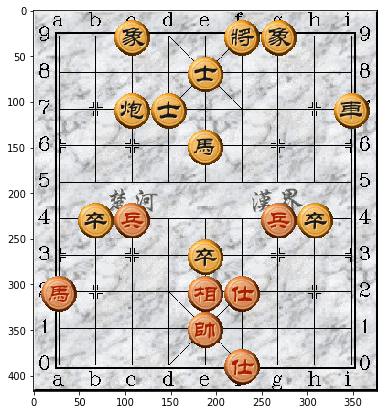

In [622]:
plt.figure(figsize=(7,7))
plt.imshow(board_visualizer.get_board_img(statestr))

In [623]:
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))

In [624]:
display_gif('./data/gif/{}.gif'.format(fname[:-4]))

# mcts 可视化，使用百度脑图

In [604]:
import random

In [605]:
!mkdir data/mstc_vis

mkdir: 无法创建目录"data/mstc_vis": 文件已存在


In [606]:
extra = {"font-weight":"bold","background":"#73a1bf","resource":[]}
def re_get_km_json(tree,statestr,is_root=True,c_puct=5,move="",depth=100):
    retval = {'data':{}}
    retval['data']['text'] = "Q {:.4f} u {:.4f} visit {} move {}".format(tree._Q,tree._u,tree._n_visits,move)
    visits = []
    chind_keys = []
    
    childern_mks = []
    if depth > 0:
        for one_chind_key in tree._children:
            if tree._children[one_chind_key]._n_visits == 0:
                continue
            visits.append(tree._children[one_chind_key]._n_visits)
            chind_keys.append(one_chind_key)
            childern_mks.append(re_get_km_json(tree._children[one_chind_key]
                                                ,GameBoard.sim_do_action(one_chind_key,statestr)
                                                ,move=one_chind_key,depth=depth - 1
                                              )
                               )
        if visits:
            visits = np.asarray(visits)
            childern_mks[np.argmax(visits)]['data'].update(extra)
    retval['children'] = childern_mks
        
    return retval

def get_km_json(mstc_policy,statestr,c_puct=5,depth=100):
    rootdic = re_get_km_json(mstc_policy._root,statestr,c_puct=5,depth=depth)
    retdata = {
            "root":rootdic,
            "template": "default",
            "theme": "fresh-blue",
            "version": "1.4.43"
        }
    return retdata

In [607]:
mcts_policy_async = mcts_async.MCTS(policy_value_fn_queue,n_playout=400,search_threads=16
                                    ,virtual_loss=0.02,c_puct=5,policy_loop_arg=True,dnoise=False)
start = time.time()
gs = GameState()
gs.currentplayer = 'w'
gs.statestr = statestr
acts_3, act_probs_3 = mcts_policy_async.get_move_probs(gs,temp=1e-2,verbose=False
                                                       ,predict_workers=[prediction_worker(mcts_policy_async)])
print(time.time() - start)

4.027296781539917


In [608]:
def get_random_policy(policies):
    sumnum = sum([i[1] for i in policies])
    randnum = random.random() * sumnum
    tmp = 0
    for val,pos in policies:
        tmp += pos
        if tmp > randnum:
            return val

In [609]:
datajson = get_km_json(mcts_policy_async,statestr,depth=40)#GameState().statestr)

In [610]:
datajson.keys(),acts_3[-1]

(dict_keys(['root', 'template', 'theme', 'version']), 'e1e0')

In [611]:
import json

In [612]:
with open('data/mstc_vis/sample.km','w') as whdl:
    json.dump(datajson,whdl)

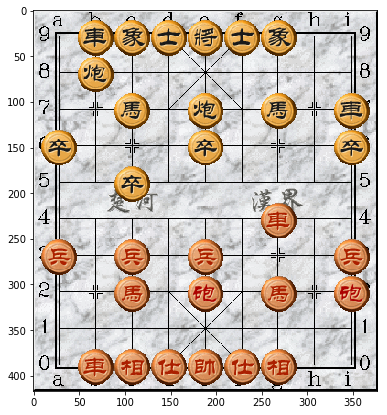

In [160]:
plt.figure(figsize=(7,7,))
plt.imshow(board_visualizer.get_board_img(statestr))

# result of self-play evaluation

In [578]:
import os
import numpy as np
evalue_dir = 'data/validate/2018-05-30_20-00-13/'

In [579]:
chessplays = os.listdir(evalue_dir)

In [580]:
new_score = 0
old_score = 0

nw_win,nw_lose,ow_win,ow_lose = 0,0,0,0
peaces = 0
for one_play in chessplays:
    if 'mcts_peace' in one_play or 'mcts_-1' in one_play:
        new_score += 0.5
        old_score += 0.5
        peaces += 1
        continue
    if 'new-old' in one_play:
        if 'mcts_w' in one_play:
            new_score += 1
            nw_win += 1
        elif 'mcts_b' in one_play:
            old_score += 1
            nw_lose += 1
    elif 'old-new' in one_play:
        if 'mcts_b' in one_play:
            new_score += 1
            ow_lose += 1
        elif 'mcts_w' in one_play:
            old_score += 1
            ow_win += 1

In [581]:
new_score = new_score / len(chessplays)
old_score = old_score / len(chessplays)

In [582]:
new_score,old_score,len(chessplays)

(0.49615384615384617, 0.5038461538461538, 130)

In [583]:
nw_win,nw_lose,ow_win,ow_lose,peaces

(11, 11, 17, 16, 75)

In [584]:
np.log10(1 / new_score - 1) * 400

2.6726341426061233

In [585]:
np.log10(1 / old_score - 1) * 400

-2.6726341426061233

In [511]:
elo = np.log10(1 / old_score - 1) * 400

In [512]:
cat 'data/log_update'

data/validate/2018-05-21 87 
data/validate/2018-05-24 100 
data/validate/2018-05-25 107.53812491703198 60 16 33 49 42
data/validate/2018-05-26 -5.21192470064795 54 30 51 24 41
data/validate/2018-05-27 41.89414020800522 48 26 43 45 38
data/validate/2018-05-28 -43.65778777002724 44 49 42 22 43
data/validate/2018-05-28_13-10-33 -10.426196175570936 47 34 51 32 36
data/validate/2018-05-29_01-21-34 -1.7371924043128415 48 42 33 26 51
data/validate/2018-05-29_13-20-24 -3.474471674037067 46 32 42 26 54

data/validate/2018-05-30_13-04-06 0.0 9 5 10 6 41


In [514]:
sorted([i[:-6] for i in os.listdir('data/prepare_weight/') if '.index' in i])[::-1][:2]

['2018-05-30_18-41-03', '2018-05-30_16-00-13']

In [335]:
stamp = sorted([i for i in os.listdir('data/validate/') if '_blank' not in i])[-1]

In [336]:
stamp

'2018-05-28'